In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Preprocessing function
def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (112, 112))
    img = img.flatten()
    return img

# Random Forest on Original Data

In [ ]:
brain = []
tumor = []
file_paths = []
for label in [0, 1]:
    images = os.path.join('/content/drive/MyDrive/MA540/original', str(label))
    for file in os.listdir(images):
        file_path = os.path.join(images, file)
        brain.append(preprocess_image(file_path))
        tumor.append(label)
        file_paths.append(file_path)

brain = np.array(brain)
tumor = np.array(tumor)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(brain, tumor, test_size=0.3, stratify = tumor, random_state=0)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train, random_state=0)

In [ ]:
print(X_tr.shape, y_tr.shape)

(141, 12544) (141,)


Selecting the best parameters using GridSearch

In [ ]:
params = {
    'n_estimators': [10, 50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
}

In [ ]:
rf = RandomForestClassifier(random_state=0)
grid_search = GridSearchCV(rf, params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_tr, y_tr)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30],
                         'n_estimators': [10, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [ ]:
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 100}


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7894736842105263


In [ ]:
from sklearn.metrics import recall_score

sensitivity = recall_score(y_test, y_pred)
print("Sensitivity:", sensitivity)

Sensitivity: 0.8936170212765957


In [ ]:
correct = np.where(y_pred==y_test)[0]
print( "Found %d correct labels" % len(correct))
correct

Found 60 correct labels


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 47, 50, 51, 52, 53, 54, 57, 58, 60, 61,
       63, 64, 66, 68, 69, 70, 71, 73, 75])

In [ ]:
correct[0:9]

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

Found 60 correct labels


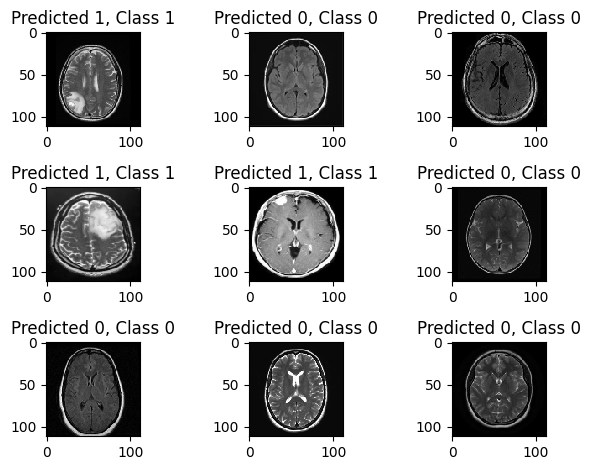

In [ ]:
correct = np.where(y_pred == y_test)[0]
print("Found %d correct labels" % len(correct))
i = 0
for val in correct[:9]:
    plt.subplot(3, 3, i + 1)
    img = X_test[val].reshape(112, 112)  # Reshape the flattened image to 112x112 pixels
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[val], y_test[val]))
    i += 1
plt.tight_layout()

In [ ]:
incorrect = np.where(y_pred!=y_test)[0]
print( "Found %d incorrect labels" % len(incorrect))
incorrect

Found 16 incorrect labels


array([11, 22, 26, 44, 45, 46, 48, 49, 55, 56, 59, 62, 65, 67, 72, 74])

Found 16 incorrect labels


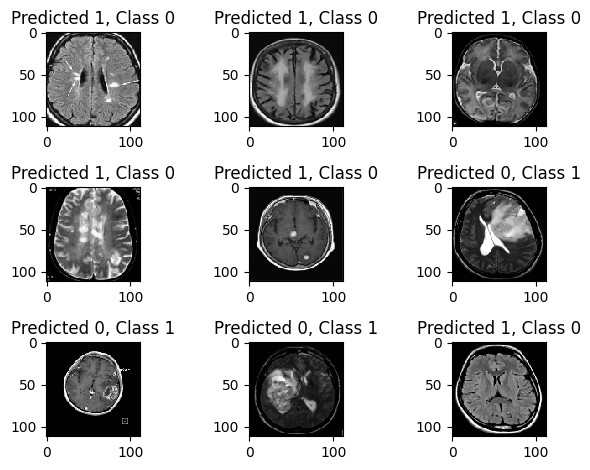

In [ ]:
incorrect = np.where(y_pred != y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
i = 0
for val in incorrect[:9]:
    plt.subplot(3, 3, i + 1)
    img = X_test[val].reshape(112, 112)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[val], y_test[val]))
    i += 1
plt.tight_layout()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

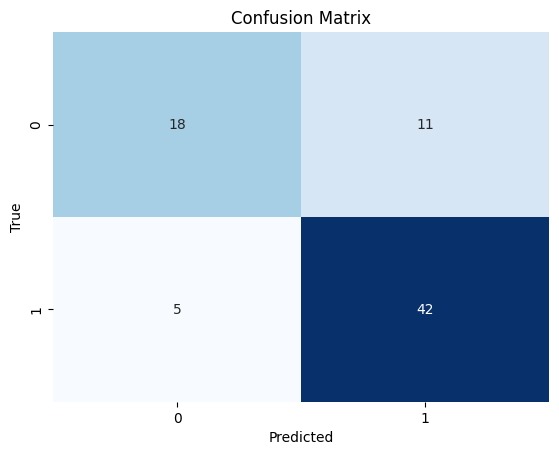

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

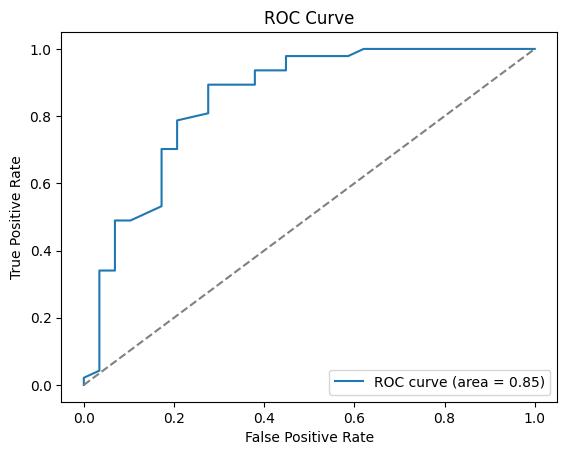

In [ ]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

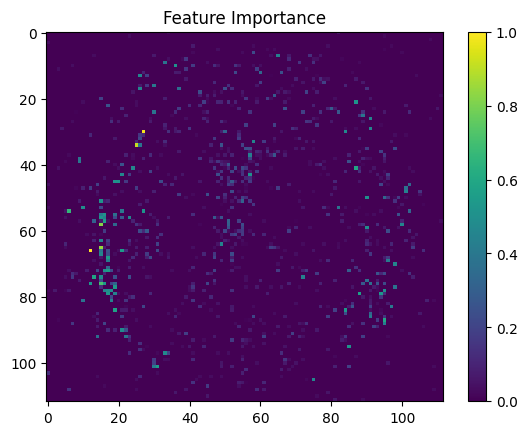

In [ ]:
from matplotlib.colors import Normalize
importances = rf.feature_importances_
importances = importances.reshape(112, 112)
norm = Normalize(vmin=importances.min(), vmax=importances.max())
normalized_importances = norm(importances)

plt.figure()
plt.imshow(normalized_importances, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Feature Importance")
plt.show()

# Random Forest on New Data

In [ ]:
brain = []
tumor = []
file_paths = []
for label in [0, 1]:
    images = os.path.join('/content/drive/MyDrive/MA540/generated', str(label))
    for file in os.listdir(images):
        file_path = os.path.join(images, file)
        brain.append(preprocess_image(file_path))
        tumor.append(label)
        file_paths.append(file_path)

brain = np.array(brain)
tumor = np.array(tumor)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(brain, tumor, test_size=0.3, stratify = tumor, random_state=0)

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train,y_train, test_size=0.2, stratify=y_train, random_state=0)

In [ ]:
print(X_tr.shape, y_tr.shape)

(191, 12544) (191,)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_tr, y_tr)

RandomForestClassifier(random_state=0)

In [ ]:
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7378640776699029


In [ ]:
sensitivity = recall_score(y_test, y_pred)
print("Sensitivity:", sensitivity)

Sensitivity: 0.7580645161290323


In [ ]:
correct = np.where(y_pred==y_test)[0]
print( "Found %d correct labels" % len(correct))
correct

Found 76 correct labels


array([  2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  13,  15,  16,
        17,  19,  20,  22,  23,  24,  25,  26,  27,  29,  31,  32,  33,
        34,  35,  36,  37,  38,  40,  41,  42,  43,  44,  45,  49,  50,
        51,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  65,
        66,  67,  68,  69,  70,  71,  76,  77,  78,  82,  83,  84,  85,
        86,  87,  89,  90,  92,  93,  96,  98,  99, 101, 102])

In [ ]:
correct[0:9]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10])

Found 76 correct labels


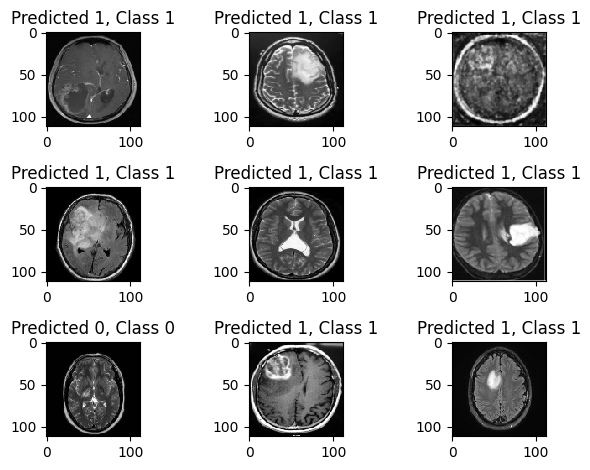

In [ ]:
correct = np.where(y_pred == y_test)[0]
print("Found %d correct labels" % len(correct))
i = 0
for val in correct[:9]:
    plt.subplot(3, 3, i + 1)
    img = X_test[val].reshape(112, 112) 
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[val], y_test[val]))
    i += 1
plt.tight_layout()

In [ ]:
incorrect = np.where(y_pred!=y_test)[0]
print( "Found %d incorrect labels" % len(incorrect))
incorrect

Found 27 incorrect labels


array([  0,   1,  11,  14,  18,  21,  28,  30,  39,  46,  47,  48,  52,
        64,  72,  73,  74,  75,  79,  80,  81,  88,  91,  94,  95,  97,
       100])

Found 27 incorrect labels


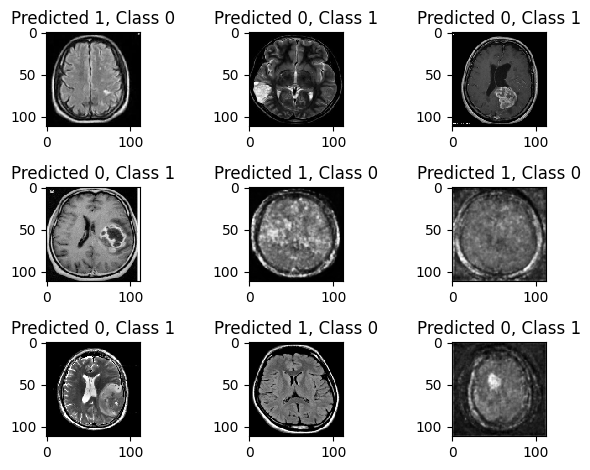

In [ ]:
incorrect = np.where(y_pred != y_test)[0]
print("Found %d incorrect labels" % len(incorrect))
i = 0
for val in incorrect[:9]:
    plt.subplot(3, 3, i + 1)
    img = X_test[val].reshape(112, 112)
    plt.imshow(img, cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_pred[val], y_test[val]))
    i += 1
plt.tight_layout()

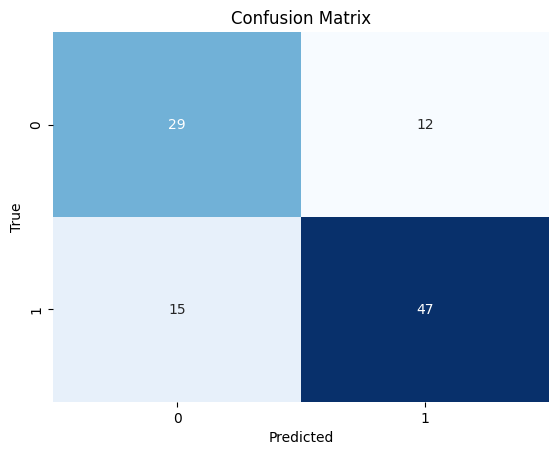

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

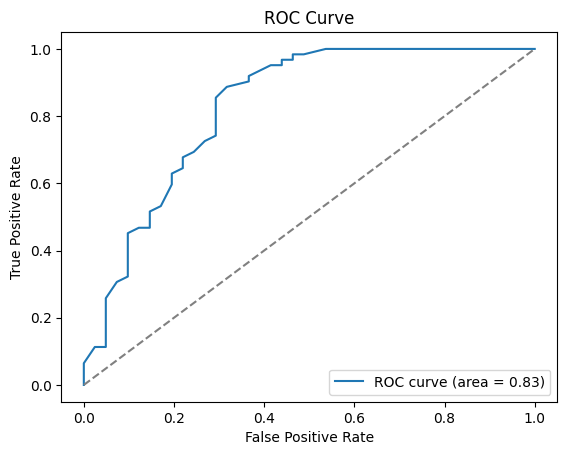

In [ ]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

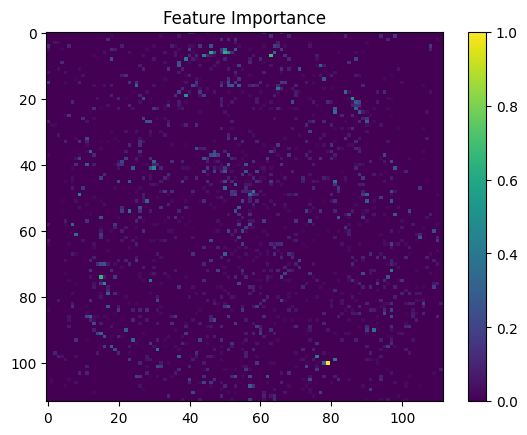

In [ ]:
from matplotlib.colors import Normalize
importances = rf.feature_importances_
importances = importances.reshape(112, 112)
norm = Normalize(vmin=importances.min(), vmax=importances.max())
normalized_importances = norm(importances)

plt.figure()
plt.imshow(normalized_importances, cmap="viridis", aspect="auto")
plt.colorbar()
plt.title("Feature Importance")
plt.show()